In [1]:
import torch
import torch.nn as nn
import clip
from PIL import Image
import pandas as pd
import requests
import os.path as osp
import pickle
import random
import numpy as np
from pathlib import Path
import sys
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import shutil

c:\users\aphri\miniconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [10]:
def read_pickle(dir):
    with open(dir, 'rb') as handle:
        b = pickle.load(handle)
    return b


def write_pickle(dir, data):
    with open(dir, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        

class Timer:
    def __init__(self):

        self.t1 = None

    @staticmethod
    def delta_to_string(td):

        res_list = []

        def format():
            return ", ".join(reversed(res_list)) + " elapsed."

        seconds = td % 60
        td //= 60
        res_list.append(f"{round(seconds,3)} seconds")

        if td <= 0:
            return format()

        minutes = td % 60
        td //= 60
        res_list.append(f"{minutes} minutes")

        if td <= 0:
            return format()

        hours = td % 24
        td //= 24
        res_list.append(f"{hours} hours")

        if td <= 0:
            return format()

        res_list.append(f"{td} days")

        return format()

    def __enter__(self):

        self.t1 = time.time()

    def __exit__(self, *args, **kwargs):

        t2 = time.time()
        td = t2 - self.t1

        print(self.delta_to_string(td))

        
def top_n(input_dict, n):
    return dict(sorted(input_dict.items(), key=itemgetter(1), reverse=True)[:n])


def find_products(text_input, category_df, image_pickle_path):

    text_input = [text_input]

    # stage one, compare categories
    category_df = category_df[~category_df["encoded_category"].isna()]
    categories = list(category_df["category"].values)

    categories_features = torch.stack(list(category_df["encoded_category"].values))
    encoded_texts = clip.tokenize(text_input).to(device)

    with torch.no_grad():

        text_features = model.encode_text(encoded_texts)

        categories_features /= categories_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity =  100 * categories_features @ text_features.T

    res = dict(zip(categories, similarity.reshape(-1).tolist()))

    res = sorted(res.items(), key=itemgetter(1), reverse=True)

    n = 10
    res = res[:n]
    res_set = set([r[0] for r in res])
    
    # do image matching
    res = []
    for cat in res_set:
        store_path = osp.join(image_pickle_path, f"{cat}.pkl")
        cat_res = read_pickle(store_path)
        res.append(cat_res)
    res = pd.concat(res, axis=0)
    
    uniq_ids = list(res["uid"].values)
    image_features = torch.stack(list(res["encoded_image"].values))
    similarity =  100 * image_features @ text_features.T
    res = dict(zip(uniq_ids, similarity.reshape(-1).tolist()))
    res = sorted(res.items(), key=itemgetter(1), reverse=True)
    
    n = 5
    res = res[:n]
    res_set = set([r[0] for r in res])
    
    return res_set


def show_images(res):
    n = len(res)
    fig, ax = plt.subplots(1, n)

    fig.set_figheight(5)
    fig.set_figwidth(5 * n)
    
    iterable = True
    try:
       it = ax[0]
    except:
        iterable = False

    if not iterable:
        img_path = image_path(res[0])
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis("off")
    else:
        for i, image in enumerate(res):
            img_path = image_path(image)
            img = mpimg.imread(img_path)

            ax[i].imshow(img)
            ax[i].axis('off')
            # ax[i].set_title(get_label(image), fontsize=8)

    plt.subplots_adjust(wspace=0, hspace=0.1)
    plt.show()
    
    
def image_path(uid):
    return osp.join(image_storage, f"{uid}.jpg")

In [17]:
model_path = "C:/Users/aphri/Documents/t0002/work/data/w210_data/finetuned_model/finetuned_model.pt"
pickle_path = "C:/Users/aphri/Documents/t0002/work/data/w210_data/data_finetuned_pickle"
image_pickle_path = "C:/Users/aphri/Documents/t0002/work/data/w210_data/data_finetuned_image_pickle"
image_storage = "demo_data/target_images"

In [8]:
category_df = read_pickle(osp.join(pickle_path, "categories.pkl"))

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [43]:
if osp.exists(model_path):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    # optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

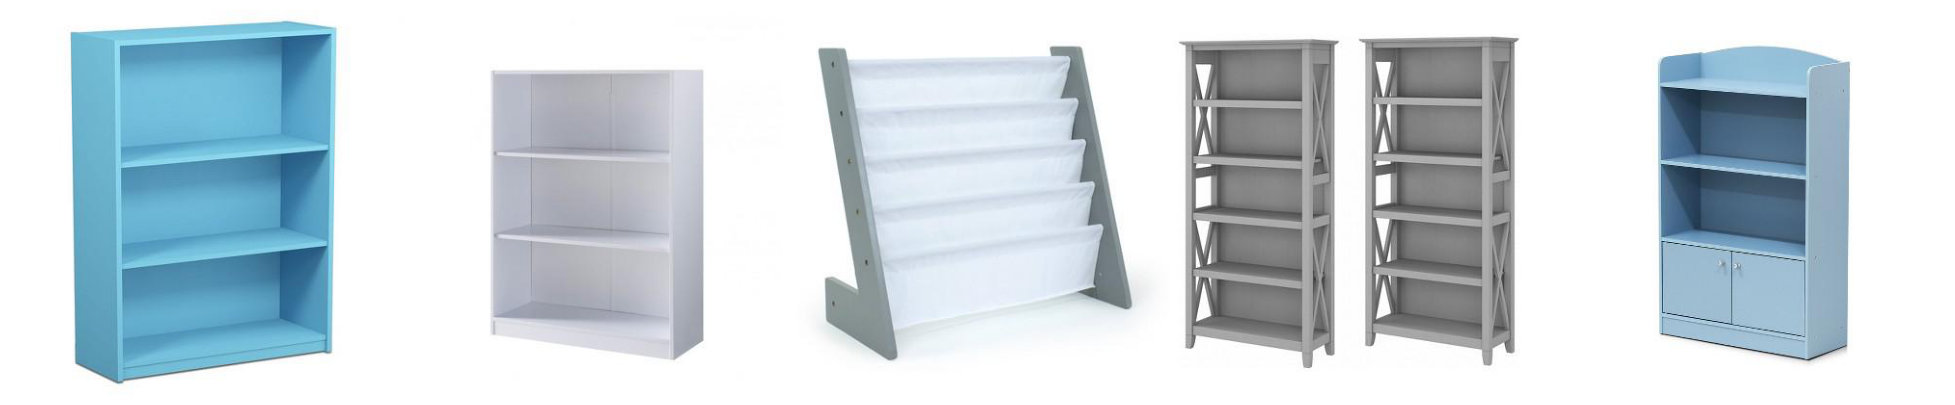

2.83 seconds elapsed.


In [19]:
query1 = "I am looking for a blue closet"
with Timer():
    show_images(find_products(query1, category_df, image_pickle_path))

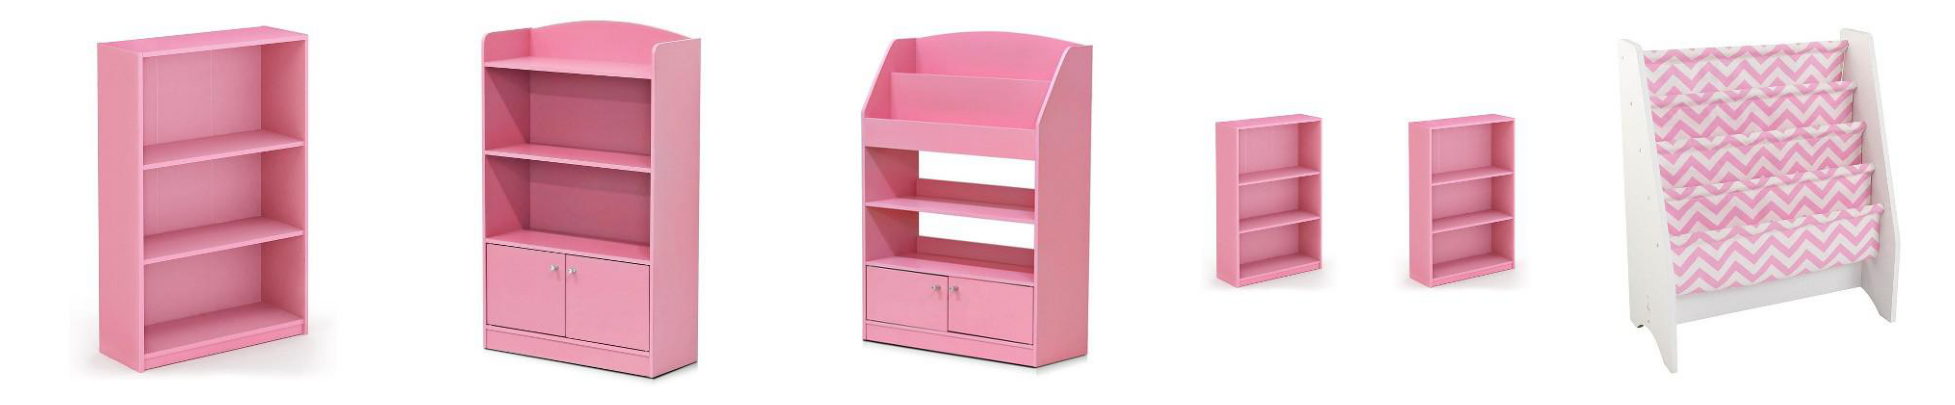

2.635 seconds elapsed.


In [26]:
query2 = "I am looking for a red bookself"
with Timer():
    show_images(find_products(query2, category_df, image_pickle_path))

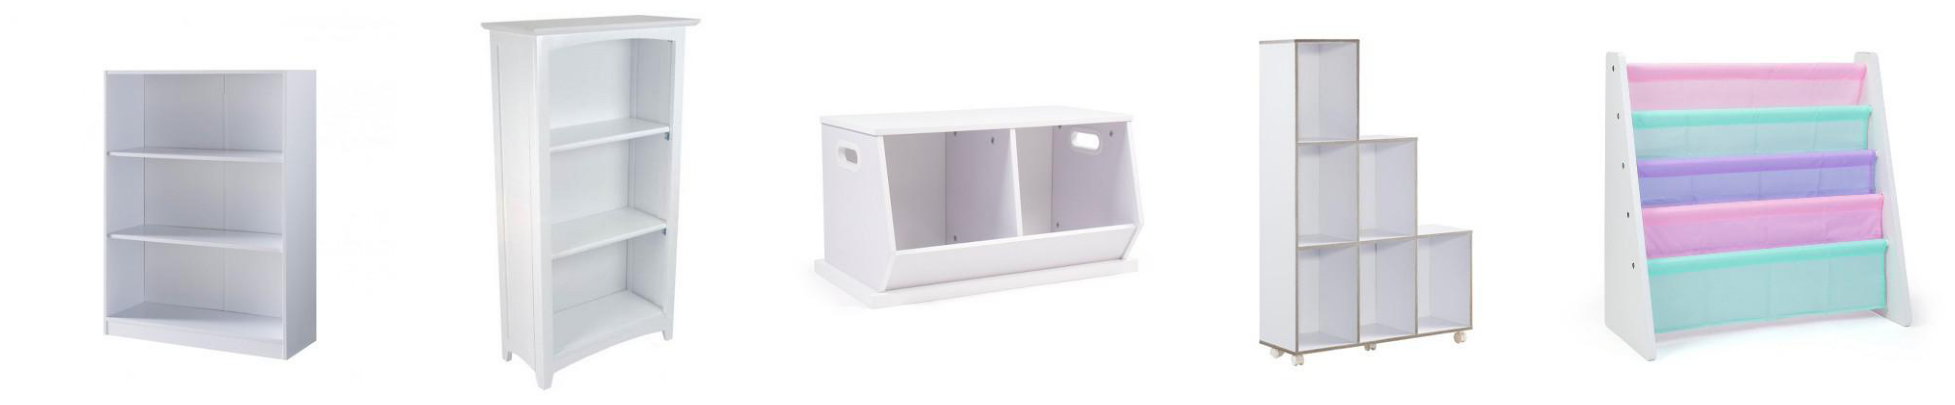

2.613 seconds elapsed.


In [29]:
query3 = "I am looking for a bookcase"
with Timer():
    show_images(find_products(query3, category_df, image_pickle_path))

In [45]:
import torch.nn.functional as F


def get_similarity_score(query, category_df, image_pickle_path):
    res = find_products(query, category_df, image_pickle_path)
    image = torch.cat([preprocess(Image.open(image_path(uid))).unsqueeze(0) for uid in res]).to(device)
    with torch.no_grad():
        eimage_list = list(model.encode_image(image))
        
    image_features = torch.stack(eimage_list)
    
    text_input = [query]
    encoded_texts = clip.tokenize(text_input).to(device)
    with torch.no_grad():
        text_features = model.encode_text(encoded_texts)
    
    similarity_scores = F.cosine_similarity(text_features, image_features)
    return similarity_scores

In [ ]:
s1 = get_similarity_score(query1, category_df, image_pickle_path)
s1

tensor([0.4416, 0.4516, 0.4515, 0.4659, 0.4793])

In [53]:
s1.mean()

tensor(0.4580)

In [51]:
s2 = get_similarity_score(query2, category_df, image_pickle_path)
s2

tensor([0.4575, 0.4343, 0.4526, 0.4412, 0.4522])

In [54]:
s2.mean()

tensor(0.4476)

In [52]:
s3 = get_similarity_score(query3, category_df, image_pickle_path)
s3

tensor([0.4575, 0.4343, 0.4526, 0.4412, 0.4522])

In [55]:
s3.mean()

tensor(0.4476)